I simulated the possible position offset due to the photometric varibility and estimated the influence of the amplitude of this variation on the orientation angle of the yearly CRF.

The source `0552+398` was chosen as the test source since it has the maximum number of sessions.

The amplitude of the variation ranges from 1 mas to 10 mas.

In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, join
import astropy.units as u

# My progs
from myprogs.vlbi.ts_func import get_ts
from tool_func import calc_orient_new, random_walk
from linear_fit import linfit2d
from myprogs.catalog.read_icrf import read_icrf3
from myprogs.StatsFunc.rms_calc import rms_calc
from myprogs.catalog.pos_diff import radio_cat_diff_calc

np.random.seed(3)

Data directory.

In [2]:
ts_dir = "/Users/Neo/Astronomy/data/vlbi/nju/series-10step"
sou_list_file = "{}/sou_list_4_ts.txt".format(ts_dir)

In [3]:
sou_rw = "0552+398"

In [4]:
# Source list
sou_list = Table.read(sou_list_file, format="ascii")
def_list = Table.read("../data/icrf3sx-def-sou.txt", format="ascii")

sou_list = join(sou_list, def_list)

In [5]:
icrf3sx = read_icrf3(wv="sx")

icrf3def = icrf3sx[icrf3sx["type"] == "D"]

In [6]:
def calc_wmean(x, err):
    """Calculate the weighted mean.
    """

    if len(x) == 1:
        wmean,  wmerr = x[0], err[0]
    else:
        wmean = np.dot(x, err**-2) / np.sum(err**-2)
        wmerr = np.sum(1/err) / np.sum(err**-2)

    return wmean, wmerr

In [7]:
def calc_mean_pos(sou_list, ts_dir, sigma_var):

    sou_name = []
    epoch = []
    mean_ra = []
    mean_dec = []
    mean_ra_err = []
    mean_dec_err = []
    mean_ra_dec_cor = []

    # Annually average the source positions
    for soui in sou_list["iers_name"]:

        coordts = get_ts(soui, ts_dir)
        ra0, dec0 = np.median(coordts["ra"]), np.median(coordts["dec"])

        if soui == sou_rw:
            # Add random walk process to the coordinate time series for this source
            dra_rw, ddec_rw = random_walk(coordts["jyear"],
                                          t_scale=5,
                                          sigma_var=sigma_var)

            coordts["ra"] = ra0 + dra_rw / 3.6e6
            coordts["dec"] = dec0 + ddec_rw / 3.6e6

        # Caculate the annual mean position
        for year in range(1979, 2021):
            coordts2 = coordts[((coordts["jyear"] >= year) &
                                (coordts["jyear"] < year + 1))]

            if len(coordts2) >= 1:
                ra0, ra0_err = calc_wmean(coordts2["ra"], coordts2["ra_err"])
                dec0, dec0_err = calc_wmean(coordts2["dec"],
                                            coordts2["dec_err"])
                ra_dec_cor = np.median(coordts2["ra_dec_corr"])

                sou_name.append(soui)
                epoch.append(int(year))
                mean_ra.append(ra0)
                mean_dec.append(dec0)
                mean_ra_err.append(ra0_err)
                mean_dec_err.append(dec0_err)
                mean_ra_dec_cor.append(ra_dec_cor)

    # Construct an Astropy.Table object to store the results
    mean_pos_table = Table([
        sou_name, epoch, mean_ra, mean_ra_err, mean_dec, mean_dec_err,
        mean_ra_dec_cor
    ],
                           names=[
                               "iers_name", "year", "ra", "ra_err", "dec",
                               "dec_err", "ra_dec_corr"
                           ])

    return mean_pos_table

In [8]:
def fetch_data_for_year(mean_pos_table, year):
    """
    """

    mask = (mean_pos_table["year"] == year)
    sub_table = mean_pos_table[mask]

    return sub_table

In [9]:
def orient_for_yearly_crf(years, sou_list, ts_dir, sigma_var, icrf3def):

    num = len(years)

    pmt = np.zeros((num, 8))
    err = np.ones((num, 8))

    mean_pos_table = calc_mean_pos(sou_list, ts_dir, sigma_var)
    # Add unit information
    mean_pos_table["ra"].unit = u.deg
    mean_pos_table["dec"].unit = u.deg
    mean_pos_table["ra_err"].unit = u.mas
    mean_pos_table["dec_err"].unit = u.mas

    for i, year in enumerate(years):
        year_crf = fetch_data_for_year(mean_pos_table, year)

        # ICRF3 defining sources
        pos_oft = radio_cat_diff_calc(year_crf, icrf3def, sou_name="iers_name")
        N, pmt[i], err[i] = calc_orient_new(pos_oft)

    return pmt, err

In [10]:
def estimate_axis_stability(years, sou_list, ts_dir, sigma_var, icrf3def):

    pmt, err = orient_for_yearly_crf(years, sou_list, ts_dir, sigma_var,
                                     icrf3def)

    wx = pmt[:, 3]
    wy = pmt[:, 4]
    wz = pmt[:, 5]
    wx_err = err[:, 3]
    wy_err = err[:, 4]
    wz_err = err[:, 5]

    wmean1, wrms1, wstd1 = rms_calc(wx, wx_err)
    wmean2, wrms2, wstd2 = rms_calc(wy, wy_err)
    wmean3, wrms3, wstd3 = rms_calc(wz, wz_err)

    result = {}
    result["std1"] = wstd1
    result["std2"] = wstd2
    result["std3"] = wstd3

    return result

In [11]:
years = np.concatenate(([1984], np.arange(1986, 2021)))

In [12]:
sigmas = np.arange(1, 11, 1)

wrms1 = np.zeros(len(sigmas))
wrms2 = np.zeros(len(sigmas))
wrms3 = np.zeros(len(sigmas))

In [13]:
for i, sigma in enumerate(sigmas):
    
    results = estimate_axis_stability(years, sou_list, ts_dir, sigma, icrf3def)
    wrms1[i] = results["std1"]
    wrms2[i] = results["std2"]
    wrms3[i] = results["std3"]

/Users/Neo/scisoft/opt64/lib/python3.9/site-packages/myprogs/catalog/pos_err.py:168: RuntimeWarning: invalid value encountered in sqrt
  M, m = np.sqrt(M2), np.sqrt(m2)
/Users/Neo/scisoft/opt64/lib/python3.9/site-packages/myprogs/catalog/pos_err.py:168: RuntimeWarning: invalid value encountered in sqrt
  M, m = np.sqrt(M2), np.sqrt(m2)
/Users/Neo/scisoft/opt64/lib/python3.9/site-packages/myprogs/catalog/pos_err.py:168: RuntimeWarning: invalid value encountered in sqrt
  M, m = np.sqrt(M2), np.sqrt(m2)
/Users/Neo/scisoft/opt64/lib/python3.9/site-packages/myprogs/catalog/pos_err.py:168: RuntimeWarning: invalid value encountered in sqrt
  M, m = np.sqrt(M2), np.sqrt(m2)
/Users/Neo/scisoft/opt64/lib/python3.9/site-packages/myprogs/catalog/pos_err.py:168: RuntimeWarning: invalid value encountered in sqrt
  M, m = np.sqrt(M2), np.sqrt(m2)
/Users/Neo/scisoft/opt64/lib/python3.9/site-packages/myprogs/catalog/pos_err.py:168: RuntimeWarning: invalid value encountered in sqrt
  M, m = np.sqrt(M2)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


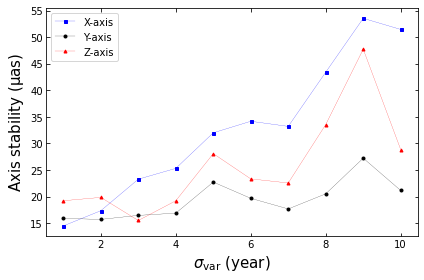

In [14]:
fig, ax = plt.subplots()

ax.errorbar(sigmas,
            wrms1,
            color="blue",
            ms=3,
            fmt="-s",
            elinewidth=0.5,
            lw=0.2,
            label="X-axis",
            capsize=1)
ax.errorbar(sigmas,
            wrms2,
            color="black",
            ms=3,
            fmt="-o",
            elinewidth=0.5,
            lw=0.2,
            label="Y-axis",
            capsize=1)
ax.errorbar(sigmas,
            wrms3,
            color="red",
            ms=3,
            fmt="-^",
            elinewidth=0.5,
            lw=0.2,
            label="Z-axis",
            capsize=1)

ax.set_xlabel("$\\sigma_{\\rm var}$ (year)", fontsize=15)
ax.set_ylabel("Axis stability ($\mathrm{\mu as}$)", fontsize=15)
ax.legend()

plt.tight_layout()
plt.savefig("../plots/axis-stability-vs-var-rw.eps")